In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from tqdm.notebook import tqdm

import polara
from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

from dataprep import transform_indices
from evaluation import topn_recommendations, downvote_seen_items

from polara.lib.tensor import hooi
from polara.lib.sparse import tensor_outer_at
from polara.evaluation.pipelines import random_grid

from sa_hooi import sa_hooi, form_attention_matrix, get_scaling_weights, generate_position_projector

from scipy.sparse import csr_matrix, coo_matrix, diags
from scipy.sparse.linalg import norm, svds
from scipy.linalg import solve_triangular, sqrtm

from IPython.utils import io

In [2]:
# Utils
def model_evaluate(recommended_items, holdout, holdout_description, alpha=3, topn=10, dcg=False):
    itemid = holdout_description['items']
    rateid = holdout_description['feedback']
    if alpha == None:
        alpha = np.median(holdout[rateid].unique())
    n_test_users = recommended_items.shape[0]
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items), f"{recommended_items.shape} != {holdout_items.shape}"
    
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    pos_mask = (holdout[rateid] >= alpha).values
    neg_mask = (holdout[rateid] < alpha).values
    
    # HR calculation
    #hr = np.sum(hits_mask.any(axis=1)) / n_test_users
    hr_pos = np.sum(hits_mask[pos_mask].any(axis=1)) / n_test_users
    hr_neg = np.sum(hits_mask[neg_mask].any(axis=1)) / n_test_users
    hr = hr_pos + hr_neg
    
    # MRR calculation
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    pos_hit_rank = np.where(hits_mask[pos_mask])[1] + 1.0
    mrr_pos = np.sum(1 / pos_hit_rank) / n_test_users
    neg_hit_rank = np.where(hits_mask[neg_mask])[1] + 1.0
    mrr_neg = np.sum(1 / neg_hit_rank) / n_test_users
    
    # Matthews correlation
    TP = np.sum(hits_mask[pos_mask]) # + 
    FP = np.sum(hits_mask[neg_mask]) # +
    cond = (hits_mask.sum(axis = 1) == 0)
    FN = np.sum(cond[pos_mask])
    TN = np.sum(cond[neg_mask])
    N = TP+FP+TN+FN
    S = (TP+FN)/N
    P = (TP+FP)/N
    C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
    
    # DCG calculation
    if dcg:
        pos_hit_rank = np.where(hits_mask[pos_mask])[1] + 1.0
        neg_hit_rank = np.where(hits_mask[neg_mask])[1] + 1.0
        ndcg = np.mean(1 / np.log2(pos_hit_rank+1))
        ndcl = np.mean(1 / np.log2(neg_hit_rank+1))
    
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    if dcg:
        return hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C, ndcg, ndcl
    else:
        return hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C

def make_prediction(tf_scores, holdout, data_description):
    for n in [5, 10, 20]:
        tf_recs = topn_recommendations(tf_scores, n)
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(tf_recs, holdout, data_description, topn=n)
        if n == 10:
            mrr10 = mrr
            hr10 = hr
            c10 = C
        print(f"HR@{n} = {hr:.4f}, MRR@{n} = {mrr:.4f}, Coverage@{n} = {cov:.4f}")
        print(f"HR_pos@{n} = {hr_pos:.4f}, HR_neg@{n} = {hr_neg:.4f}")
        print(f"MRR_pos@{n} = {mrr_pos:.4f}, MRR_neg@{n} = {mrr_neg:.4f}")
        print(f"Matthews@{n} = {C:.4f}")
        print("-------------------------------------")
    
    return mrr10, hr10, c10

def valid_mlrank(mlrank):
    '''
    Only allow ranks that are suitable for truncated SVD computations
    on unfolded compressed tensor (the result of ttm product in HOOI).
    '''
    #s, r1, r2, r3 = mlrank
    s, r1, r3 = mlrank
    r2 = r1
    #print(s, r1, r2, r3)
    return r1*r2 > r3 and r1*r3 > r2 and r2*r3 > r1

## Preprocess data

In [3]:
def full_preproccessing(data = None):
    if (data is None):
        data = get_movielens_data("ml-1m.zip", include_time=True)
    test_timepoint = data['timestamp'].quantile(
    q=0.8, interpolation='nearest'
    )
    
    labels, levels = pd.factorize(data.movieid)
    data.movieid = labels

    labels, levels = pd.factorize(data.userid)
    data.userid = labels
    
#     if (data["rating"].nunique() > 5):
#         data["rating"] = data["rating"] * 2
        
    data["rating"] = data["rating"].astype(int)

    test_data_ = data.query('timestamp >= @test_timepoint')
    train_data_ = data.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
    )
    
    training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')
    test_data = reindex(test_data_, data_index['items'])

    testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
    )
    testset_valid_, holdout_valid_ = leave_one_out(
        testset_, target='timestamp', sample_top=True, random_state=0
    )

    test_users_val = np.intersect1d(testset_valid_.userid.unique(), holdout_valid_.userid.unique())
    testset_valid = testset_valid_.query('userid in @test_users_val').sort_values('userid')
    holdout_valid = holdout_valid_.query('userid in @test_users_val').sort_values('userid')

    test_users = np.intersect1d(testset_.userid.unique(), holdout_.userid.unique())
    testset = testset_.query('userid in @test_users').sort_values('userid')
    holdout = holdout_.query('userid in @test_users').sort_values('userid')
    
    assert holdout_valid.set_index('userid')['timestamp'].ge(
        testset_valid
        .groupby('userid')
        ['timestamp'].max()
    ).all()

    data_description = dict(
        users = data_index['users'].name,
        items = data_index['items'].name,
        feedback = 'rating',
        n_users = len(data_index['users']),
        n_items = len(data_index['items']),
        n_ratings = training['rating'].nunique(),
        min_rating = training['rating'].min(),
        test_users = holdout_valid[data_index['users'].name].drop_duplicates().values, # NEW
        n_test_users = holdout[data_index['users'].name].nunique() # NEW CHECK
    )

    return training, testset_valid, holdout_valid, testset, holdout, data_description, data_index

In [4]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing()

Filtered 177 invalid observations.


## Model

In [5]:
class MVDataset(Dataset):
    def __init__(self, data, data_description):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        return self.tensor[idx], self.matrix[idx]

In [6]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2, hid3):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        self.VT = nn.Linear(hid1, n_items)
        self.W = nn.Linear(n_ratings, hid3)
        self.WT = nn.Linear(hid3, n_ratings)
#         self.L = nn.Linear(n_ratings, hid2)
#         self.Linv = nn.Linear(hid2, n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
#         self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode
#         x = torch.transpose(self.V(torch.transpose(self.W(self.L(x)), -1, -2)), -1, -2)
        x = torch.transpose(self.V(torch.transpose(self.W(x), -1, -2)), -1, -2)
        # decode
#         output = torch.transpose(self.VT(torch.transpose(self.Linv(self.WT(x)), -1, -2)), -1, -2)
        output = torch.transpose(self.VT(torch.transpose(self.WT(x), -1, -2)), -1, -2)
#         print(output.shape)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

ae = AE(data_description['n_items'], data_description['n_ratings'], 100, 50, 20).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())

In [15]:
# Training the AE
n_epochs = 100
history = []

for epoch in range(1, n_epochs + 1):   
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    history.append(train_loss / len(train_dataloader))
        
    print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

epoch: 1 loss: 0.4140553976712602
epoch: 2 loss: 0.31763626350445695
epoch: 3 loss: 0.2634862016760901
epoch: 4 loss: 0.22943014911051546
epoch: 5 loss: 0.20271022941512562
epoch: 6 loss: 0.17864976538701005
epoch: 7 loss: 0.15892916806181717
epoch: 8 loss: 0.14224362641238095
epoch: 9 loss: 0.12650025024842682
epoch: 10 loss: 0.10822111435150833
epoch: 11 loss: 0.0960387433791875
epoch: 12 loss: 0.08489581057976248
epoch: 13 loss: 0.07388198509644926
epoch: 14 loss: 0.06669347265853864
epoch: 15 loss: 0.06070153035697866
epoch: 16 loss: 0.056337652553556564
epoch: 17 loss: 0.053256068169400934
epoch: 18 loss: 0.05086023255847813
epoch: 19 loss: 0.04934638272622105
epoch: 20 loss: 0.04827419609138359
epoch: 21 loss: 0.046956763041209194
epoch: 22 loss: 0.045898484854439224
epoch: 23 loss: 0.04492983293862602
epoch: 24 loss: 0.0441970450503661
epoch: 25 loss: 0.04327204038671563
epoch: 26 loss: 0.042602756043219385
epoch: 27 loss: 0.04231119254945816
epoch: 28 loss: 0.0409845147170266
e

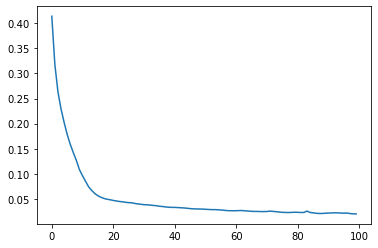

In [16]:
plt.plot(history)

In [17]:
# Testing the AE
test_loss = 0

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False

    loss = criterion(output, target)
    test_loss += loss.data.item()
    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.25729891470615424


In [18]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)
    
    output = ae(user_matrix_test)
    scores[i] = output[0].T

        
scores = scores.detach().numpy()

In [19]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0138, MRR@5 = 0.0068, Coverage@5 = 0.5340
HR_pos@5 = 0.0115, HR_neg@5 = 0.0023
MRR_pos@5 = 0.0059, MRR_neg@5 = 0.0009
Matthews@5 = 0.0024
-------------------------------------
HR@10 = 0.0247, MRR@10 = 0.0082, Coverage@10 = 0.6796
HR_pos@10 = 0.0207, HR_neg@10 = 0.0040
MRR_pos@10 = 0.0071, MRR_neg@10 = 0.0011
Matthews@10 = 0.0048
-------------------------------------
HR@20 = 0.0500, MRR@20 = 0.0100, Coverage@20 = 0.7786
HR_pos@20 = 0.0420, HR_neg@20 = 0.0081
MRR_pos@20 = 0.0086, MRR_neg@20 = 0.0014
Matthews@20 = 0.0081
-------------------------------------


(0.008229734293564082, 0.024726854514088556, 0.004805383786448424)

## Baseline

In [5]:
useridx = training[data_description['users']].values
itemidx = training[data_description['items']].values
# feedbackidx = training[data_description['feedback']].values
values = np.ones(len(itemidx))

In [6]:
user_tensor_train = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
train_dataset = SimpleDataset(user_tensor_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [22]:
class baseAE(nn.Module):
    def __init__(self, n_items, hid):
        super(baseAE, self).__init__()
        self.V = nn.Linear(n_items, hid)
        self.VT = nn.Linear(hid, n_items)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encode
        x = self.V(x)
        # decode
        output = self.VT(x)
        output = self.relu(output)
        return output

bae = baseAE(data_description['n_items'], 200).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(bae.parameters())

In [23]:
# Training the simpleAE
n_epochs = 100
history = []

for epoch in range(1, n_epochs + 1):   
    train_loss = 0
    for user_matrix in train_dataloader:
        optimizer.zero_grad()
        
        input_tensor = user_matrix.to_dense().to(device)
        
        target = input_tensor.clone()
        output = bae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    history.append(train_loss / len(train_dataloader))
        
    print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

epoch: 1 loss: 0.6932113050075059


KeyboardInterrupt: 

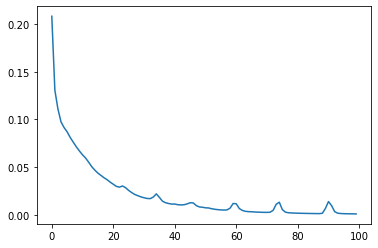

In [18]:
plt.plot(history)

In [19]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().unsqueeze(0).to(device)
    
    output = bae(user_matrix_test)
    scores[i] = output[0].T

        
scores = scores.detach().numpy()

In [24]:
# base
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0242, MRR@5 = 0.0143, Coverage@5 = 0.5042
HR_pos@5 = 0.0213, HR_neg@5 = 0.0029
MRR_pos@5 = 0.0121, MRR_neg@5 = 0.0022
Matthews@5 = 0.0229
-------------------------------------
HR@10 = 0.0385, MRR@10 = 0.0161, Coverage@10 = 0.6283
HR_pos@10 = 0.0334, HR_neg@10 = 0.0052
MRR_pos@10 = 0.0136, MRR_neg@10 = 0.0025
Matthews@10 = 0.0211
-------------------------------------
HR@20 = 0.0696, MRR@20 = 0.0182, Coverage@20 = 0.7270
HR_pos@20 = 0.0581, HR_neg@20 = 0.0115
MRR_pos@20 = 0.0153, MRR_neg@20 = 0.0029
Matthews@20 = 0.0065
-------------------------------------


(0.016116952819080477, 0.03852788959171938, 0.021061964711250054)